# Finalise 
## Running all together

In [13]:
# ----------------------------------------------
# 📦 Import Required Libraries
# ----------------------------------------------
import os
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, roc_curve, roc_auc_score
)
from imblearn.over_sampling import SMOTE


In [14]:

# ----------------------------------------------
# 📂 Load Data
# ----------------------------------------------

train_path = "//Users/faisalmahmud/Desktop/RF_Classification_to_classify_DASS_from_Daily_Ongoing_Thoughts/Binary/FinalData/DASS_TrainData.csv"
test_path = "//Users/faisalmahmud/Desktop/RF_Classification_to_classify_DASS_from_Daily_Ongoing_Thoughts/Binary/FinalData/DASS_TestData.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [15]:


# ----------------------------------------------
# 🔧 Configuration
# ----------------------------------------------
features = [
    'Task', 'Future', 'Past', 'Self', 'People', 'External', 'Images', 'Words',
    'Sounds', 'Detailed', 'Deliberate', 'Solution', 'Intrusive', 'Knowledge',
    'Absorption', 'Distracting', 'Meaningful'
]

target_variables = ['DASS_total_Class', 'DASS_D_Class', 'DASS_A_Class', 'DASS_S_Class']

label_map = {
    'DASS_total_Class': 'DASS Total',
    'DASS_D_Class': 'Depression',
    'DASS_A_Class': 'Anxiety',
    'DASS_S_Class': 'Stress'
}

class_names = ['Normal', 'Severe']

combined_output_dir = "//Users/faisalmahmud/Desktop/RF_Classification_to_classify_DASS_from_Daily_Ongoing_Thoughts/Binary/Results"

os.makedirs(combined_output_dir, exist_ok=True)

In [21]:

# ----------------------------------------------
# 🚀 Train Models + Collect Results
# ----------------------------------------------
results = {}

for target_variable in target_variables:
    print(f"\n🔍 Processing target: {target_variable}")
    
    # Split features and labels
    X_train = df_train[features].values
    y_train = df_train[target_variable].values
    X_test = df_test[features].values
    y_test = df_test[target_variable].values

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train-validation split
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train_res, y_train_res, test_size=0.2, random_state=42, stratify=y_train_res
    )

    
    # Grid search for best RandomForest model
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [20, 30, 40],
        'max_features': ['sqrt'],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True]
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_split, y_train_split)
    best_rf = grid_search.best_estimator_
    

    # Evaluate model
    y_pred = best_rf.predict(X_val)
    y_probs = best_rf.predict_proba(X_val)[:, 1]
    
    
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_val, y_probs)

    print(f"\n✅ Results for {label_map[target_variable]}")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print("  Classification Report:")
    print(classification_report(y_val, y_pred, target_names=class_names))
    

    # SHAP values
    explainer = shap.TreeExplainer(best_rf)
    shap_values = explainer.shap_values(X_val)

    # Store results
    results[target_variable] = {
        'model': best_rf,
        'X_val': X_val,
        'y_val': y_val,
        'y_pred': y_pred,
        'y_probs': y_probs,
        'confusion_matrix': confusion_matrix(y_val, y_pred),
        'roc_auc': roc_auc,
        'roc_curve': roc_curve(y_val, y_probs),
        'shap_values': shap_values
    }




🔍 Processing target: DASS_total_Class

✅ Results for DASS Total
  Accuracy : 0.8190
  Precision: 0.8267
  Recall   : 0.8190
  F1 Score : 0.8179
  Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.74      0.80       547
      Severe       0.78      0.90      0.83       547

    accuracy                           0.82      1094
   macro avg       0.83      0.82      0.82      1094
weighted avg       0.83      0.82      0.82      1094


🔍 Processing target: DASS_D_Class

✅ Results for Depression
  Accuracy : 0.8575
  Precision: 0.8666
  Recall   : 0.8575
  F1 Score : 0.8566
  Classification Report:
              precision    recall  f1-score   support

      Normal       0.81      0.94      0.87       597
      Severe       0.92      0.78      0.85       596

    accuracy                           0.86      1193
   macro avg       0.87      0.86      0.86      1193
weighted avg       0.87      0.86      0.86      1193


🔍 Process

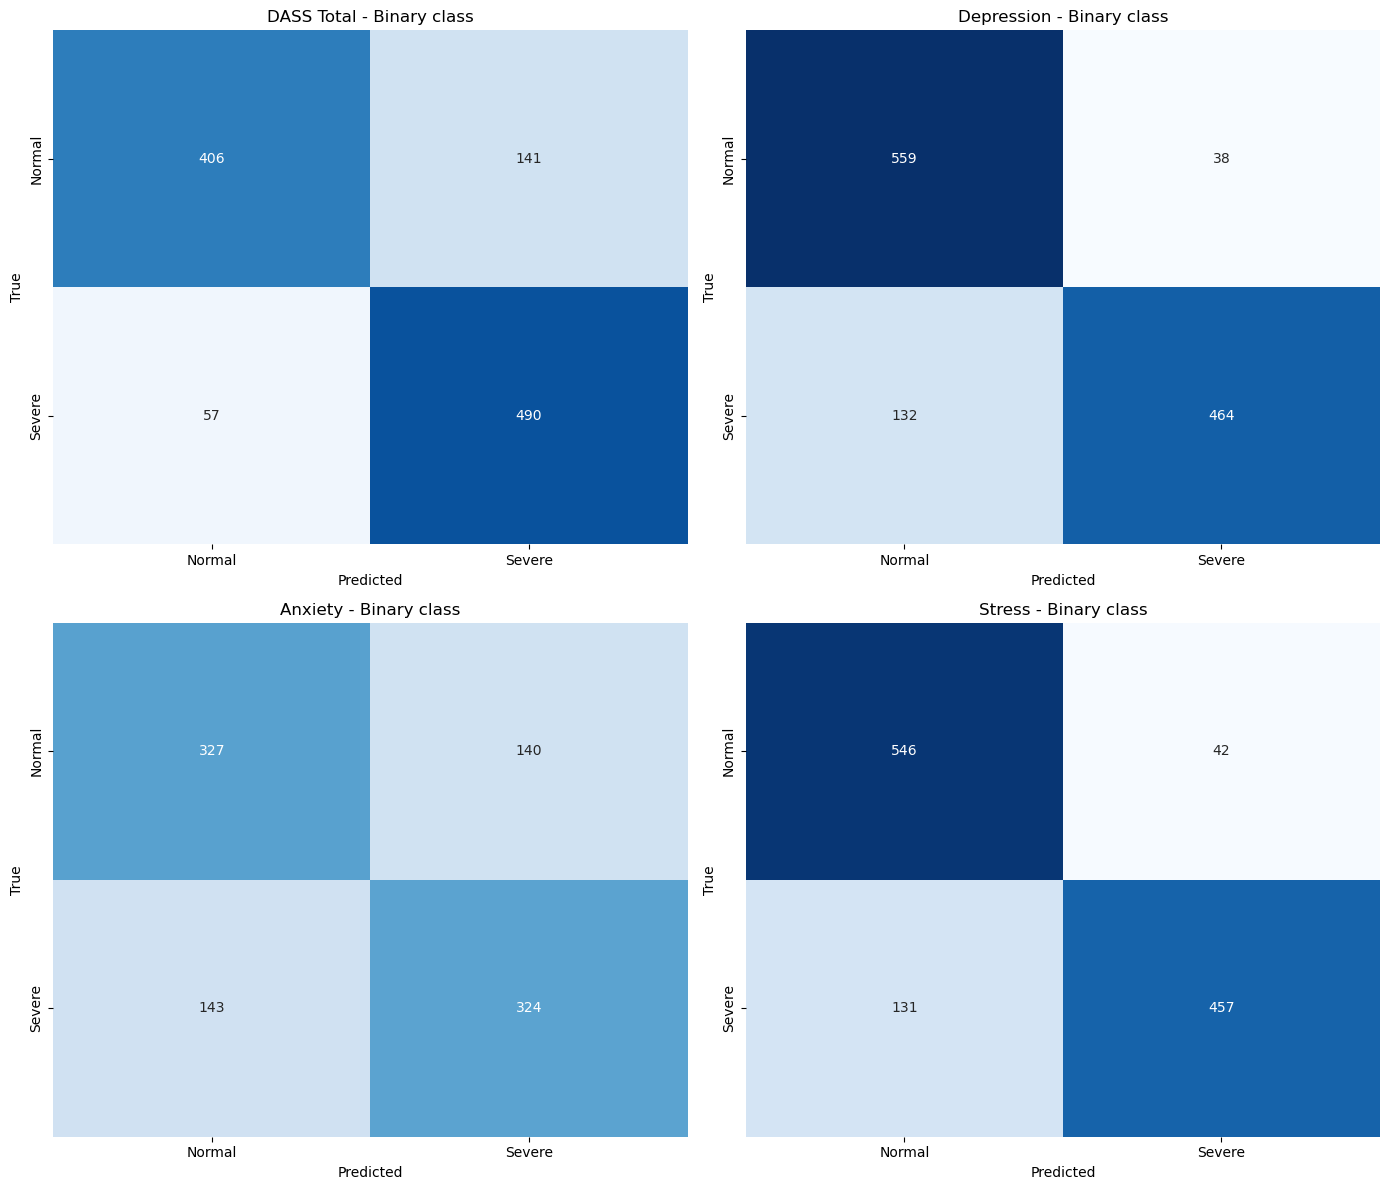

In [22]:
import numpy as np

# Step 1: Collect all values from confusion matrices to get global min and max
all_values = []
for target_variable in target_variables:
    cm = results[target_variable]['confusion_matrix']
    all_values.append(cm)

# Convert to a single NumPy array and find global min/max
all_values = np.array(all_values)
vmin = all_values.min()
vmax = all_values.max()

# Step 2: Plot heatmaps with shared color scale
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, target_variable in enumerate(target_variables):
    cm = results[target_variable]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, ax=axes[i],
                vmin=vmin, vmax=vmax)  # Apply consistent scale
    axes[i].set_title(f"{label_map[target_variable]} - Binary class")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.savefig(os.path.join(combined_output_dir, "combined_confusion_matricesGlobalClr.png"))
plt.show()

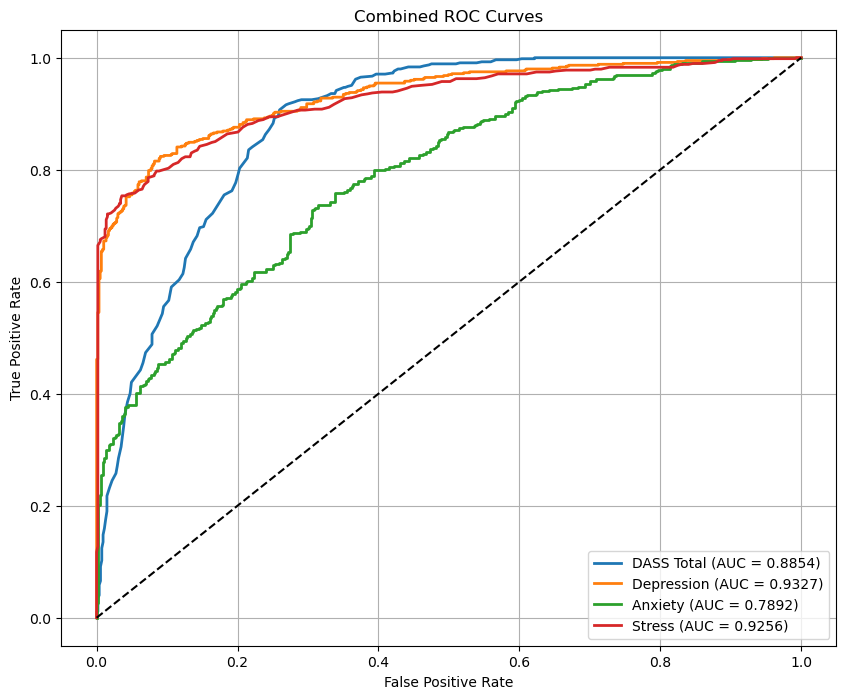

In [23]:
# ----------------------------------------------
# 📈 Plot: Combined ROC Curves
# ----------------------------------------------
plt.figure(figsize=(10, 8))

for target_variable in target_variables:
    fpr, tpr, _ = results[target_variable]['roc_curve']
    auc = results[target_variable]['roc_auc']
    plt.plot(fpr, tpr, lw=2, label=f"{label_map[target_variable]} (AUC = {auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(os.path.join(combined_output_dir, "combined_roc_curvesFinal.png"))
plt.show()

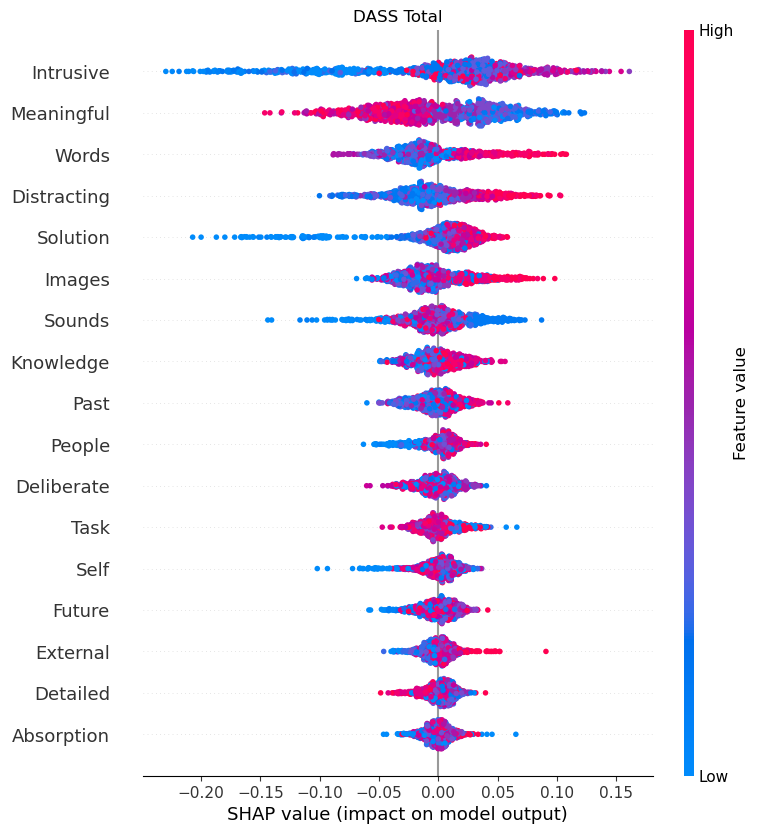

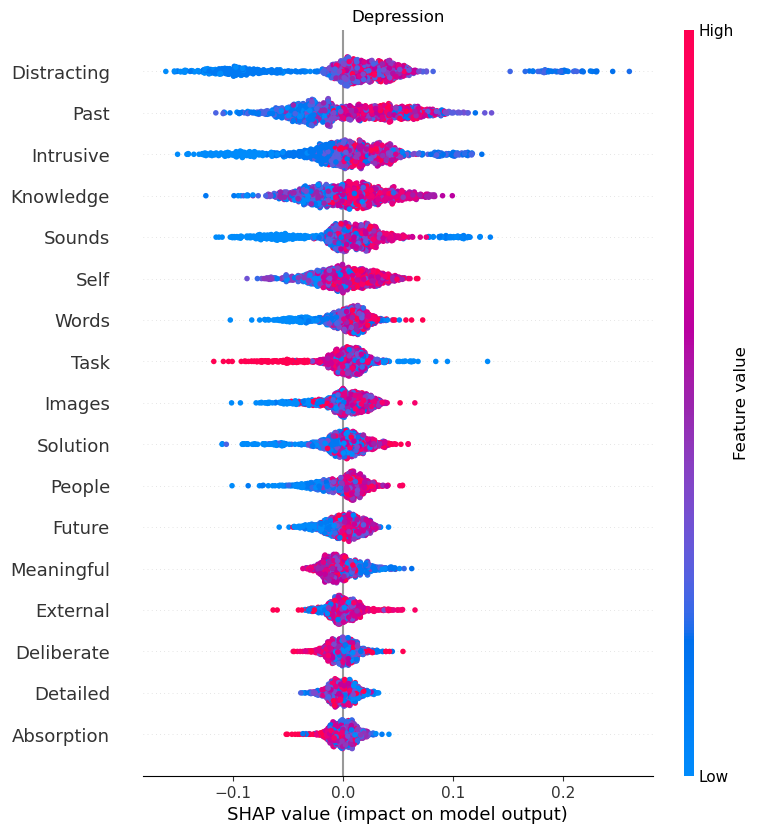

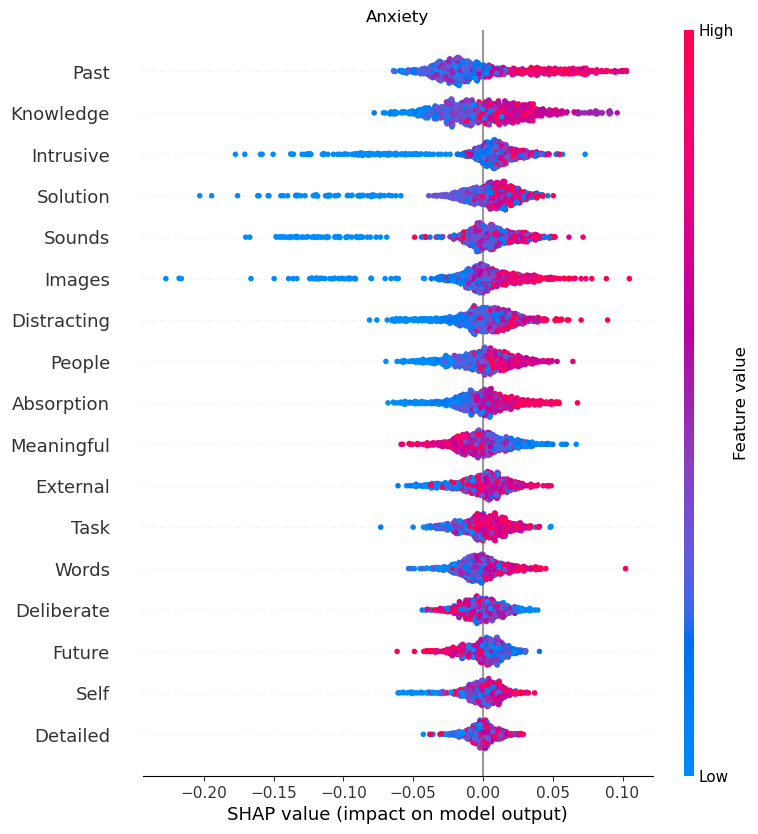

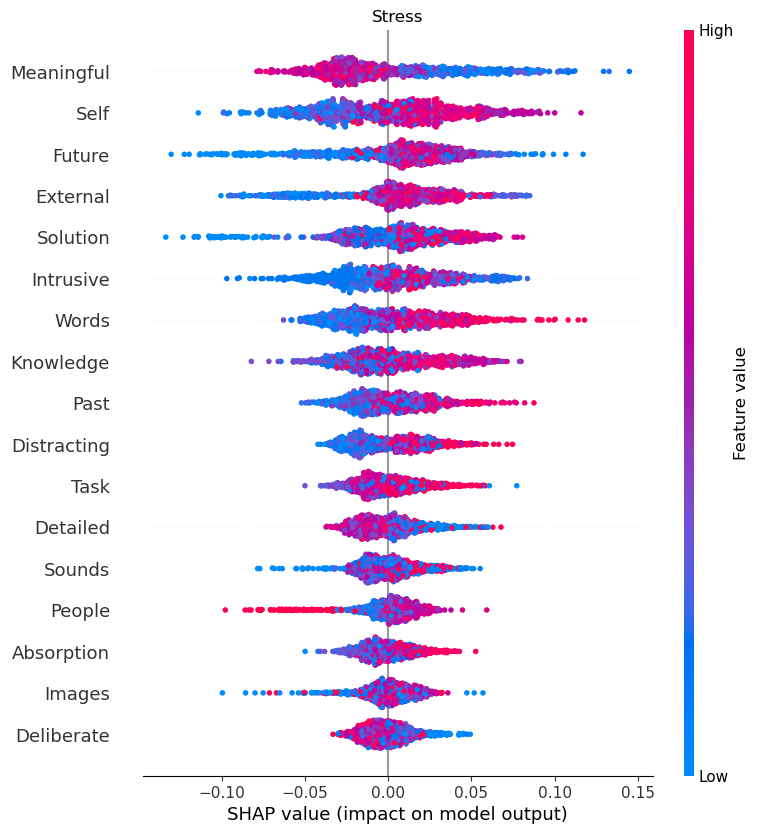

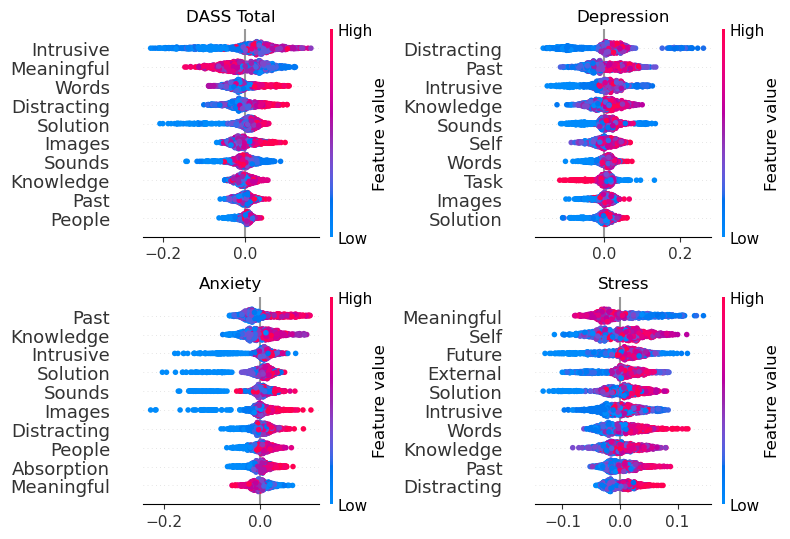

In [24]:

# ----------------------------------------------
# 🔍 Plot: SHAP Summary (All Features, Individually)
# ----------------------------------------------
for target_variable in target_variables:
    shap_values = results[target_variable]['shap_values']
    X_val = results[target_variable]['X_val']
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values[1], X_val, feature_names=features, show=False)
    plt.title(label_map[target_variable])

    filepath = os.path.join(combined_output_dir, f"shap_summary_{target_variable}_Final.png")
    plt.savefig(filepath, bbox_inches='tight')
    plt.show()
    plt.close()

# ----------------------------------------------
# 🔍 Plot: SHAP Summary (Top 10, Combined 2x2 Grid)
# ----------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, target_variable in enumerate(target_variables):
    shap_values = results[target_variable]['shap_values']
    X_val = results[target_variable]['X_val']
    
    plt.sca(axes[i])
    shap.summary_plot(shap_values[1], X_val, feature_names=features, show=False, max_display=10)
    axes[i].set_title(label_map[target_variable])
    axes[i].set_xlabel('')  # Removes SHAP footer text

plt.tight_layout()
path = os.path.join(combined_output_dir, "combined_shap_summary_top10_2x2_no_footerFinal.png")
plt.savefig(path, bbox_inches='tight')
plt.show()

